## Overview
A common problem in statistical physics is the calculation of so-called observables. These quantities contain special, aggregated information about a system with many constituents. For example, pressure is a particular observable for a system of gas particles confined in a box. This gives useful information on its physical properties and sweps the details, such as the position of every single atom in the box, under the rug. 

These observables are expressed as averages over the *statistics* of the system, as we have only approximate (probabilistic) knowledge of its state. Unfortunately, evaluating these averages requires formal access to every possible realization of the system that could be realized and is hence a member of the ensemble corresponding to the probability distribution. DMFT is concerned with coming up with an efficient technique of approximating these averages. 

## A toy problem
Instead of considering a complex system, let's consider a more trivial case. Consider a random variable $x$ which follows the probability distribution 
$$ p(x)=e^{S_0(x)+S_V(x)}. $$

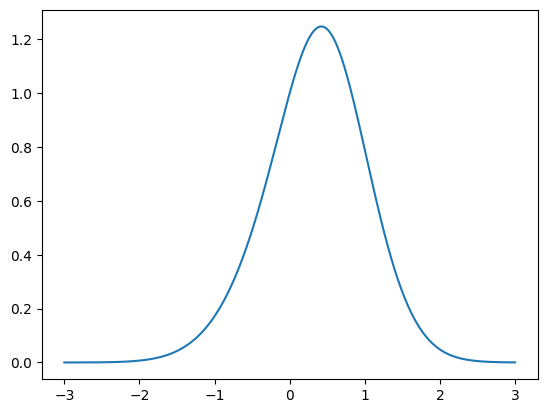

In [12]:
import matplotlib.pyplot as plt
import numpy as np

f = lambda x: np.tanh(x)

def p_x0(x):
    return np.exp(-x**2)

def p_x(x):
    return p_x0(x)*np.exp(f(x))

x = np.linspace(-3,3,1000)
plt.plot(x, p_x(x))

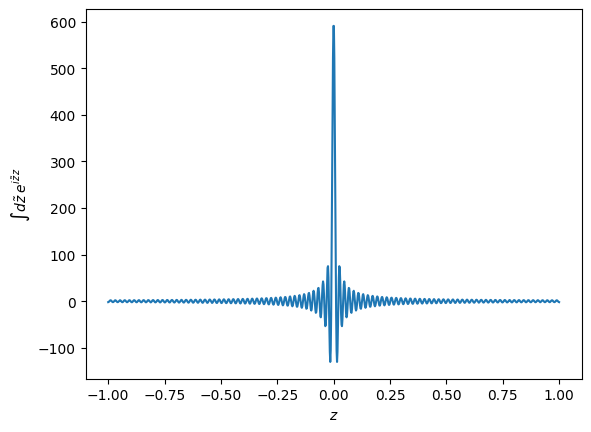

In [22]:
z_ = np.linspace(-300,300,10000)
dz_= np.diff(z_)[0]
delta_fourier = lambda z: dz_*np.sum(np.exp(1j*z_[None, :]*z[:, None]), axis=1)

z = np.linspace(-1,1,1000)
ax = plt.gca()
ax.plot(z, delta_fourier(z))
l = ax.set_xlabel("$z$")
l = ax.set_ylabel(r"$\int d\tilde z \: e^{i\tilde z z}$")



Evaluation of this integral is hard in general. In particular, if $x\in \mathbb R^N$, numerical methods might become infeasible, too. Moreover, often one would like to use analytical continuations (for example in the Replica Trick), which is only possible with closed form solutions. 

To address this, DMFT proceeds in two steps: **Decoupling** and the **saddle-point approximation**. 

### Decoupling
The main challenge with the above integral is the interplay of $x$ and $f(x)$. We can move to two independent, or decoupled, variables $x$ and $f$ instead. As [Free Lunch is rare](https://en.wikipedia.org/wiki/No_free_lunch_theorem), we have to deal with the cost of an additional integral that binds the variables by means of a Dirac-$\delta$ constraint:
$$ \int dx df \,e^{S_0(x) + f}\,\delta(f-f(x)). $$

Next, we raise the $\delta$-constraint to the exponent by the mathemagical identity $\delta(y)=\int d\tilde y\, e^{i\tilde y y}$. 



This gives
$$ \int dx df d\tilde f \:e^{S_0(x) + f + i\tilde f(f-f(x))}. $$

We can now separate the $x$-independent part of the integral
$$ 
\begin{aligned}
&\int df d\tilde f \:e^{f + i\tilde f f} \: &\underbrace{\int dx \,e^{S_0(x) - i\tilde f f(x)}}_{Z_{\text{eff}}} \\
=&\int df d\tilde f \:e^{f + i\tilde f f} \: & e^{\ln Z_{\text{eff}}} \\
=& \int df d\tilde f \: e^{S(f,\tilde f)}.\\
\end{aligned}
$$

### Saddle-point approximation
We may hope that the outer integral is well approximated at the saddle point of the respective variables, i.e.
$$ \int dy \: p(y) f(y) \approx f(y^*), \quad y^*=\text{arg stat}_y f(y). $$

These points are identified by the **stationarity conditions** $\partial_{\tilde f} S  = 0$ and $\partial_{f} S  = 0$. This gives two **self-consistent** conditions
$$
\begin{aligned}
-if^* &= \langle f(x) \rangle_{f,\tilde f^*} \\
-i\tilde f^* &= 0.
\end{aligned}
$$
The solution $f^*$ is called the **mean field** that influences the variable in eq. 1.
Plugging this solution back into $S(f,\tilde f)$ leaves us with
$$
e^{f^*} \int dx \,e^{S_0(x)},
$$
which can be solved if we know the solution to the free theory $S_0$.

(-1.3, 1.3)

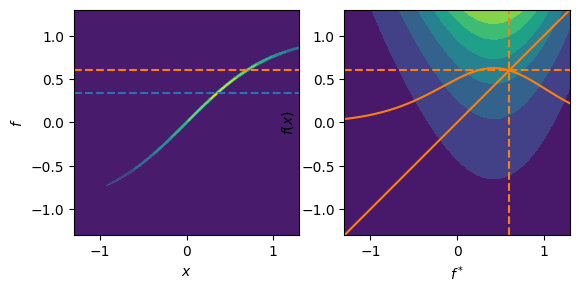

In [82]:
y = np.linspace(-1.3, 1.3, 1000)
xx, yy = np.meshgrid(x, y)

eps = 1e-2
delta = lambda z: (2*np.pi*eps**2)**-0.5*np.exp(-z**2/(2*eps**2))

def p_xy(x,y):
    return p_x0(x)*np.exp(y)*delta(y-f(x))

def p_xy_(x,y):
    return p_x0(x)*np.exp(y)

from matplotlib import ticker
fig, (ax1, ax2) = plt.subplots(1, 2)

h = ax1.contourf(x, y, (p_xy(xx,yy)))
l = ax1.set_xlabel("$x$")
l = ax1.set_ylabel("$f$")
ax1.set_aspect("equal")
ax2.set_aspect("equal")

f_star = y
f_starf_star, ff = np.meshgrid(f_star, y)
p_f_star_f = np.mean(p_xy(f_starf_star,ff), axis=0)[None,:]*np.exp(f_star)[:,None]
#p_f_star_f /= np.max(p_f_star_f, axis=0, keepdims=True)

h = ax2.contourf(f_starf_star, yy, p_f_star_f)
l1 = f_star
l2 = np.mean(p_f_star_f, axis=0)
res = l1[np.argmin(np.abs(l1-l2))]
ax2.axvline(res, ls="--", c="tab:orange")
ax2.axhline(res, ls="--", c="tab:orange")
ax2.plot(f_star, l1, c="tab:orange")
ax2.plot(f_star, l2, c="tab:orange")
ax2.set_xlabel("$f^*$")
ax2.set_ylabel("$f(x)$")

ax1.axhline(res, c="C1", ls="--")

# actual expectation
ax1.axhline(np.mean(np.exp(f(x))*p_x0(x)), c="C0", ls="--")
ax1.set_xlim(ax2.get_xlim())